# Week 38: Bi-LSTM Classifier

In [24]:
import polars as pl
from transformers import AutoModel, AutoTokenizer
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import os
import matplotlib.pyplot as plt
from datasets import load_dataset
from nlm.models import BiLSTMClassifierModel
from nlm.train_utils import train_classifier as train

from bert_utils import (
    display_results
)

import dataset

In [25]:
# Load dataset
dataset = load_dataset("coastalcph/tydi_xor_rc")
df_train = dataset["train"].to_polars()
df_val = dataset["validation"].to_polars()

df_ar_train = df_train.filter(pl.col("lang") == "ar")
df_ko_train = df_train.filter(pl.col("lang") == "ko")
df_te_train = df_train.filter(pl.col("lang") == "te")
df_arkote_train = df_train.filter(pl.col("lang").is_in(["ar", "ko", "te"]))

df_ar_val = df_val.filter(pl.col("lang") == "ar")
df_ko_val = df_val.filter(pl.col("lang") == "ko")
df_te_val = df_val.filter(pl.col("lang") == "te")
df_arkote_val = df_val.filter(pl.col("lang").is_in(["ar", "ko", "te"]))

In [26]:
# Load mBERT tokenizer
mbert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")
mbert_model = AutoModel.from_pretrained("bert-base-multilingual-uncased")
pretrained_embeddings = mbert_model.get_input_embeddings().weight.data

In [27]:
# Select device for training
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
if torch.cuda.is_available():
  device = torch.device("cuda")

print(f'Using device: {device}')

Using device: cuda


In [28]:
def dataloader_generator(
        train_dataset: list, train_labels: list, val_dataset: list,
        val_labels: list, tokenizer, device, batch_size: int = 8
) -> tuple[DataLoader, DataLoader]:
    """
    Generate DataLoader objects for training and validation datasets for use in PyTorch models.
    """
    train_tokens = tokenizer(
        train_dataset,
        truncation=True,
        max_length=65,
        padding='max_length',
        return_tensors='pt'
    ).to(device)
    train_labels = torch.tensor(train_labels).to(device)

    val_tokens = tokenizer(
        val_dataset,
        truncation=True,
        max_length=65,
        padding='max_length',
        return_tensors='pt'
    ).to(device)
    val_labels = torch.tensor(val_labels).to(device)

    train_attention_mask = train_tokens['attention_mask']
    train_input_lens = train_attention_mask.sum(dim=1)
    train_dataset = TensorDataset(
        train_tokens['input_ids'], train_input_lens, train_labels
    )

    val_attention_mask = val_tokens['attention_mask']
    val_input_lens = val_attention_mask.sum(dim=1)
    val_dataset = TensorDataset(
        val_tokens['input_ids'], val_input_lens, val_labels
    )

    train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_dl, val_dl

In [29]:
def class_model_loader(
        train_dataset: list, train_labels:list, val_dataset: list,
        val_labels: list, device, model_cache_path: str, epochs: int,
        n_classes:int = 2, model_lstm_dim: int = 100
) -> nn.Module:
    """
    Load or train a NN Model for text classification.
    """
    model = BiLSTMClassifierModel(
        pretrained_embeddings=torch.FloatTensor(pretrained_embeddings).to(device),
        n_classes=n_classes,
        lstm_dim=model_lstm_dim,
    ).to(device)

    if os.path.exists(model_cache_path):
        print("Loading cached model from", model_cache_path)
        model.load_state_dict(torch.load(model_cache_path))
    else:
        print("No cached model found. Training a new model.")
        train_dl, val_dl = dataloader_generator(train_dataset, train_labels, val_dataset, val_labels, mbert_tokenizer, device)
        losses, best_acc = train(model, train_dl, val_dl, torch.optim.Adam(model.parameters(), lr=1e-3), n_epochs=epochs, device=device, save_path=model_cache_path)
        print('Training complete. Best validation accuracy:', best_acc)

    return model


loading or generating models

In [30]:
# Arabic dataset
#arabic_model_path = "cached_data/bilstm_class_arabic"
#df_arabic_train_questions = df_ar_train["question"].to_list()
#df_arabic_train_answerable = [int(x) for x in df_ar_train["answerable"].to_list()]
#df_arabic_val_questions = df_ar_val["question"].to_list()
#df_arabic_val_answerable = [int(x) for x in df_ar_val["answerable"].to_list()]

#arabic_model = class_model_loader(df_arabic_train_questions, df_arabic_train_answerable, df_arabic_val_questions, df_arabic_val_answerable, device, arabic_model_path, epochs=10, n_classes=2, model_lstm_dim=100)

In [31]:
# Arabic dataset with context
arabic_model_path = "cached_data/bilstm_class_arabic_w_context"
df_arabic_train_questions_context = zip(df_ar_train["question"].to_list() , df_ar_train["context"].to_list())
df_arabic_train_questions_context = ["[SEP]".join([q, c]) for q, c in df_arabic_train_questions_context]
df_arabic_train_answerable = [int(x) for x in df_ar_train["answerable"].to_list()]
df_arabic_val_questions_context = zip(df_ar_val["question"].to_list() , df_ar_val["context"].to_list())
df_arabic_val_questions_context = ["[SEP]".join([q, c]) for q, c in df_arabic_val_questions_context]
df_arabic_val_answerable = [int(x) for x in df_ar_val["answerable"].to_list()]

arabic_model_w_context = class_model_loader(df_arabic_train_questions_context, df_arabic_train_answerable, df_arabic_val_questions_context, df_arabic_val_answerable, device, arabic_model_path, epochs=10, n_classes=2, model_lstm_dim=100)

Loading cached model from cached_data/bilstm_class_arabic_w_context


c:\Users\asge1\Downloads\nlp-project\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [32]:
# Korean dataset
#korean_model_path = "cached_data/bilstm_class_korean"
#df_korean_train_questions = df_ko_train["question"].to_list()
#df_korean_train_answerable = [int(x) for x in df_ko_train["answerable"].to_list()]
#df_korean_val_questions = df_ko_val["question"].to_list()
#df_korean_val_answerable = [int(x) for x in df_ko_val["answerable"].to_list()]

#korean_model = class_model_loader(df_korean_train_questions, df_korean_train_answerable, df_korean_val_questions, df_korean_val_answerable, device, korean_model_path, epochs=10, n_classes=2, model_lstm_dim=100)

In [33]:
# Korean dataset with context
korean_model_path = "cached_data/bilstm_class_korean_w_context"
df_korean_train_questions_context = zip(df_ko_train["question"].to_list() , df_ko_train["context"].to_list())
df_korean_train_questions_context = ["[SEP]".join([q, c]) for q, c in df_korean_train_questions_context]
df_korean_train_answerable = [int(x) for x in df_ko_train["answerable"].to_list()]
df_korean_val_questions_context = zip(df_ko_val["question"].to_list() , df_ko_val["context"].to_list())
df_korean_val_questions_context = ["[SEP]".join([q, c]) for q, c in df_korean_val_questions_context]
df_korean_val_answerable = [int(x) for x in df_ko_val["answerable"].to_list()]

korean_model_w_context = class_model_loader(df_korean_train_questions_context, df_korean_train_answerable, df_korean_val_questions_context, df_korean_val_answerable, device, korean_model_path, epochs=10, n_classes=2, model_lstm_dim=100)

Loading cached model from cached_data/bilstm_class_korean_w_context


In [34]:
# Telughu dataset
#telugu_model_path = "cached_data/bilstm_class_telugu"
#df_telugu_train_questions = df_te_train["question"].to_list()
#df_telugu_train_answerable = [int(x) for x in df_te_train["answerable"].to_list()]
#df_telugu_val_questions = df_te_val["question"].to_list()
#df_telugu_val_answerable = [int(x) for x in df_te_val["answerable"].to_list()]

#telugu_model = class_model_loader(df_telugu_train_questions, df_telugu_train_answerable, df_telugu_val_questions, df_telugu_val_answerable, device, telugu_model_path, epochs=10, n_classes=2, model_lstm_dim=100)

In [35]:
# Telugu dataset with context
telugu_model_path = "cached_data/bilstm_class_telugu_w_context"
df_telugu_train_questions_context = zip(df_te_train["question"].to_list() , df_te_train["context"].to_list())
df_telugu_train_questions_context = ["[SEP]".join([q, c]) for q, c in df_telugu_train_questions_context]
df_telugu_train_answerable = [int(x) for x in df_te_train["answerable"].to_list()]
df_telugu_val_questions_context = zip(df_te_val["question"].to_list() , df_te_val["context"].to_list())
df_telugu_val_questions_context = ["[SEP]".join([q, c]) for q, c in df_telugu_val_questions_context]
df_telugu_val_answerable = [int(x) for x in df_te_val["answerable"].to_list()]

telugu_model_w_context = class_model_loader(df_telugu_train_questions_context, df_telugu_train_answerable, df_telugu_val_questions_context, df_telugu_val_answerable, device, telugu_model_path, epochs=10, n_classes=2, model_lstm_dim=100)

Loading cached model from cached_data/bilstm_class_telugu_w_context


In [36]:
# Context dataset
#context_model_path = "cached_data/bilstm_class_context"
#df_arkote_train_context = df_arkote_train["context"].to_list()
#df_arkote_train_answerable = [int(x) for x in df_arkote_train["answerable"].to_list()]
#df_arkote_val_context = df_arkote_val["context"].to_list()
#df_arkote_val_answerable = [int(x) for x in df_arkote_val["answerable"].to_list()]

#context_model = class_model_loader(df_arkote_train_context, df_arkote_train_answerable, df_arkote_val_context, df_arkote_val_answerable, device, context_model_path, epochs=10, n_classes=2, model_lstm_dim=100)

predict and evaluate models

In [37]:
def predict_answerable(model: BiLSTMClassifierModel, texts: list[str], tokenizer, device) -> list[int]:
    model.eval()
    tokens = tokenizer(
        texts,
        truncation=True,
        max_length=65,
        padding='max_length',
        return_tensors='pt'
    ).to(device)

    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    input_lens = attention_mask.sum(dim=1)

    with torch.no_grad():
        logits = model(input_ids, input_lens)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().tolist()

    return preds

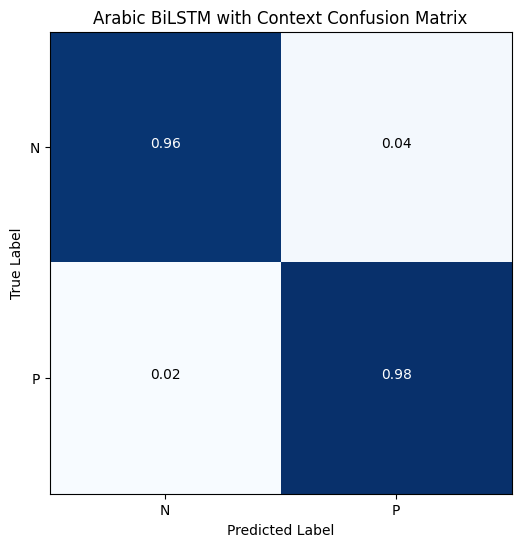

Classification Report:
              precision    recall  f1-score   support

           N       0.89      0.96      0.93        52
           P       0.99      0.98      0.99       363

    accuracy                           0.98       415
   macro avg       0.94      0.97      0.96       415
weighted avg       0.98      0.98      0.98       415



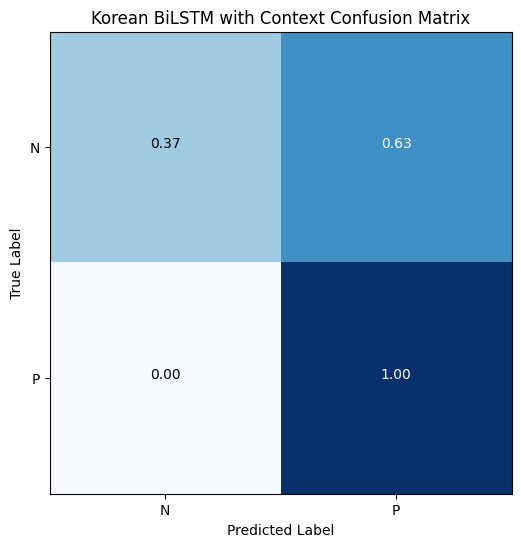

Classification Report:
              precision    recall  f1-score   support

           N       1.00      0.37      0.54        19
           P       0.97      1.00      0.98       337

    accuracy                           0.97       356
   macro avg       0.98      0.68      0.76       356
weighted avg       0.97      0.97      0.96       356



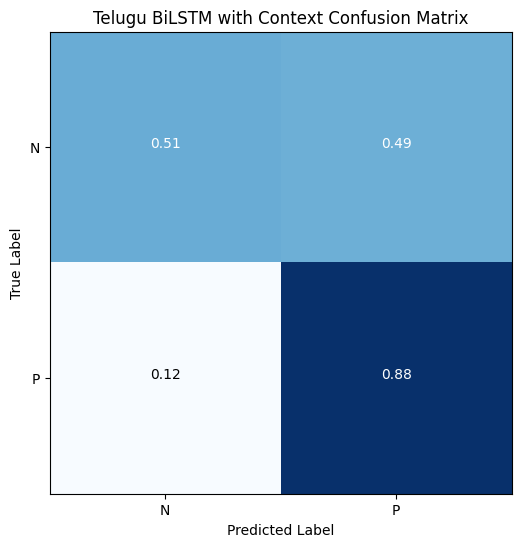

Classification Report:
              precision    recall  f1-score   support

           N       0.58      0.51      0.54        93
           P       0.85      0.88      0.87       291

    accuracy                           0.79       384
   macro avg       0.71      0.69      0.70       384
weighted avg       0.78      0.79      0.79       384



In [38]:
#display_results(
#    predict_answerable(arabic_model, df_arabic_val_questions, mbert_tokenizer, device),
#    df_arabic_val_answerable,
#    ["N", "P"],
#    title="Arabic BiLSTM Confusion Matrix"
#)
display_results(
    predict_answerable(arabic_model_w_context, df_arabic_val_questions_context, mbert_tokenizer, device),
    df_arabic_val_answerable,
    ["N", "P"],
    title="Arabic BiLSTM with Context Confusion Matrix"
)
#display_results(
#    predict_answerable(korean_model, df_korean_val_questions, mbert_tokenizer, device),
#    df_korean_val_answerable,
#    ["N", "P"],
#    title="Korean BiLSTM Confusion Matrix"
#)
display_results(
    predict_answerable(korean_model_w_context, df_korean_val_questions_context, mbert_tokenizer, device),
    df_korean_val_answerable,
    ["N", "P"],
    title="Korean BiLSTM with Context Confusion Matrix"
)
#display_results(
#    predict_answerable(telugu_model, df_telugu_val_questions, mbert_tokenizer, device),
#    df_telugu_val_answerable,
#    ["N", "P"],
#    title="Telugu BiLSTM Confusion Matrix"
#)
display_results(
    predict_answerable(telugu_model_w_context, df_telugu_val_questions_context, mbert_tokenizer, device),
    df_telugu_val_answerable,
    ["N", "P"],
    title="Telugu BiLSTM with Context Confusion Matrix"
)
#display_results(
#    predict_answerable(context_model, df_arkote_val_context, mbert_tokenizer, device),
#    df_arkote_val_answerable,
#    ["N", "P"],
#    title="Context BiLSTM Confusion Matrix"
#)